In [1]:
import pandas as pd
import shutil
from tqdm.notebook import tnrange, tqdm
import Augmentor
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv('./state-farm-distracted-driver-detection/driver_imgs_list.csv')
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [3]:
print(df["classname"].value_counts())

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64


In [4]:
big_dictionary = dict(df["classname"].value_counts())
print(big_dictionary['c8'])
print(big_dictionary)

1911
{'c0': 2489, 'c3': 2346, 'c4': 2326, 'c6': 2325, 'c2': 2317, 'c5': 2312, 'c1': 2267, 'c9': 2129, 'c7': 2002, 'c8': 1911}


In [5]:
# oversample minority classes using Augmentor
def img_oversampler_from_df(df, classname, rootdir): 
    
    big_dictionary = dict(df[classname].value_counts())
    
    class_bois= list(big_dictionary.keys())
    val_bois= list(big_dictionary.values())
    
    for i in tnrange(len(class_bois)):
    
        p = Augmentor.Pipeline(rootdir+"/"+class_bois[i]+"/")

        p.rotate(probability=1, max_left_rotation=7, max_right_rotation=7)
        p.zoom_random(probability=0.9, percentage_area=0.95)
        p.crop_random(probability=1, percentage_area=0.95)

        if max(val_bois)-val_bois[i] == 0:
            pass
        else:
            p.sample(max(val_bois)-val_bois[i])
        #print(rootdir+"/"+class_bois[i]+"/", max(val_bois)-val_bois[i])

In [ ]:
img_oversampler_from_df(df, 'classname', './state-farm-distracted-driver-detection/imgs/train')

In [5]:
p = Augmentor.Pipeline()
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.zoom_random(probability=0.9, percentage_area=0.95)
p.crop_random(probability=1, percentage_area=0.95)
p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=1)

In [6]:
# images resized to 50x50

transformations_n = transforms.Compose([
    p.torch_transform(),
    transforms.Resize((50,50), interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
        

data = torchvision.datasets.ImageFolder(root='./state-farm-distracted-driver-detection/imgs/train', transform=transformations_n)
print(len(data))

24890


Label: 4


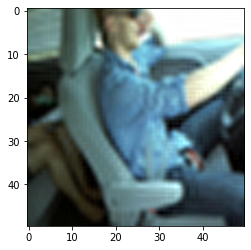

In [7]:
train_set, val_set = torch.utils.data.random_split(data, [len(data)-2000, 2000])
sample = next(iter(train_set))
image,label = sample 
x=np.transpose(image, (1, 2, 0))
u_x = x / 2 + 0.5  # to prevent 'Clipping input data to the valid range ..'
plt.imshow(u_x, interpolation='sinc')
print("Label:", label)

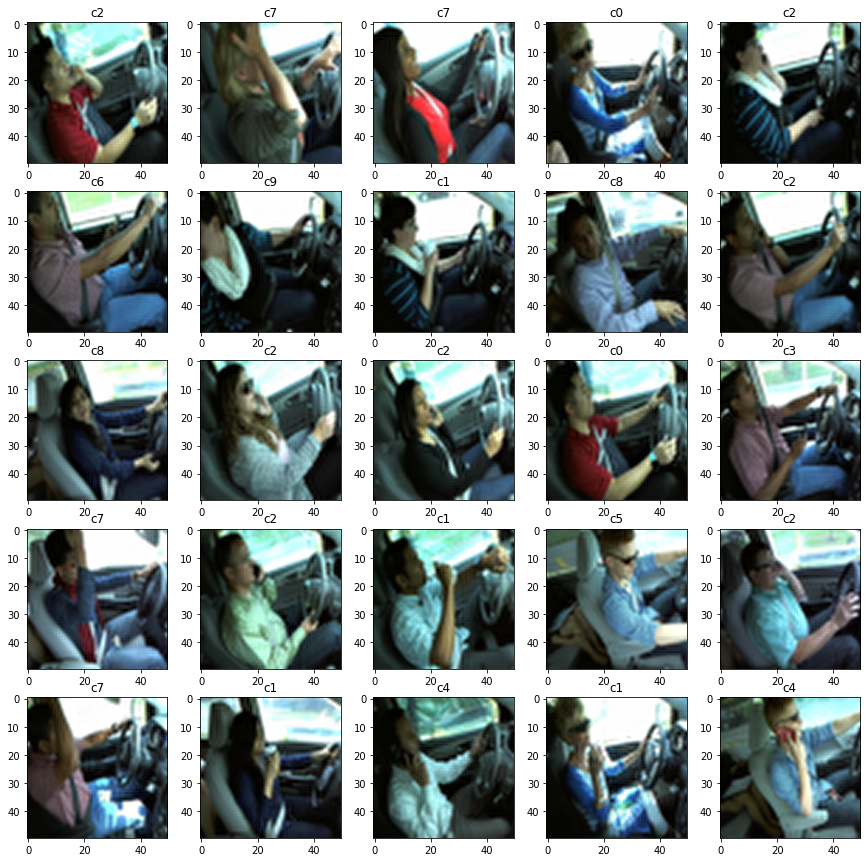

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [10]:
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=5
    ,shuffle=True
)

emotions = ['c0', 'c3', 'c4', 'c6', 'c2', 'c5', 'c1', 'c9', 'c7', 'c8']

fig, axs = plt.subplots(5, 5, figsize=(15,15))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for image_list in (train_loader):
            np_image=image_list[0][0]
            label_tensor=image_list[1][0]
            max_index = (label_tensor.item())
            label_emotion = emotions[max_index]
            
            image=np_image
            x=np.transpose(image, (1, 2, 0))
            u_x = x / 2 + 0.5 

            axs[j,i].imshow(u_x, interpolation='sinc', cmap='gray')
            axs[j,i].title.set_text(label_emotion)
            break
plt.show()